# Neural Turing Machine with Keras

Definitions:  
$h$ controller RNN state. $M$ memory (a matrix). $r$ and $w$ read and write vectors, output of a softmax, thus a probability distribution, they are used to do weighted averaging (it seems that differentiable attention is the new name for that) over the rows of $M$. The rows of $M$ are the different "memory locations".

Internal algorithm:  
1) Using $h_{t-1}$, update the reading vector $r_t = f_r(r_{t-1}, h_{t-1})$  
2) Read from memory $m_t = read(r_t, M_{t-1})$  
3) Using the input and the read vector, update the RNN controller state $RNN$: $h_t = RNN(x_t, m_t, h_{t-1})$  
4) Using $h_t$, update the writing vector $w_t = f_w(w_{tm1}, h_t)$  
5) Write to memory $M_t = write(M_{t-1}, h_t, w_t)$.  

For details see [Graves et. al.](http://arxiv.org/pdf/1410.5401v2.pdf). Next we are going to run the Copy experiment in Keras using ``#ThankYouTheano`` backend.

# Copy Problem

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import logging
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import cPickle

from theano import tensor, function

from keras.datasets import mnist
# from keras.models import Graph, Sequential
from keras.layers.core import TimeDistributedDense, Dropout, Activation, Flatten, Masking
from keras.layers.recurrent import LSTM
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD
from keras import backend as K

from seya.layers.ntm import NeuralTuringMachine as NTM
from seya.models_prev import Sequential

from IPython import display

Using Theano backend.


Using gpu device 0: GeForce GTX 680 (CNMeM is disabled)


In [2]:
batch_size = 100

h_dim = 128
n_slots = 121
m_length = 20
input_dim = 8
lr = 1e-4
clipnorm = 10

In [3]:
# Neural Turing Machine

ntm = NTM(h_dim, n_slots=n_slots, m_length=m_length, shift_range=3,
          inner_rnn='lstm', return_sequences=True, input_dim=input_dim)
model = Sequential()
# model.add(Masking(input_shape=(None, input_dim)))
model.add(ntm)
model.add(TimeDistributedDense(input_dim))
model.add(Activation('sigmoid'))

In [4]:
sgd = Adam(lr=lr, clipnorm=clipnorm)
model.compile(loss='binary_crossentropy', optimizer=sgd)

In [5]:
# LSTM - Run this for comparison

#sgd = Adam(lr=lr, clipnorm=clipnorm)

#model4 = Sequential()
#model4.add(LSTM(input_dim=input_dim, output_dim=h_dim*2, return_sequences=True))
#model4.add(LSTM(output_dim=h_dim*2, return_sequences=True))
#model4.add(LSTM(output_dim=h_dim*2, return_sequences=True))
#model4.add(TimeDistributedDense(input_dim))
#model4.add(Activation('sigmoid'))

#model4.compile(loss='binary_crossentropy', optimizer=sgd)


# Dataset

In [6]:
def get_sample(batch_size=128, n_bits=8, max_size=20, min_size=1):
    # generate samples with random length
    inp = np.zeros((batch_size, 2*max_size-1, n_bits))
    out = np.zeros((batch_size, 2*max_size-1, n_bits))
    sw = np.zeros((batch_size, 2*max_size-1, 1))
    for i in range(batch_size):
        t = np.random.randint(low=min_size, high=max_size)
        x = np.random.uniform(size=(t, n_bits)) > .5
        for j,f in enumerate(x.sum(axis=-1)): # remove fake flags
            if f>=n_bits:
                x[j, :] = 0.
        del_flag = np.ones((1, n_bits))
        inp[i, :t+1] = np.concatenate([x, del_flag], axis=0)
        out[i, t+1:(2*t+1)] = x
        sw[i, t+1:(2*t+1)] = 1
    return inp, out, sw

In [ ]:
def get_sample(batch_size=128, n_bits=8, max_size=20, min_size=1):
    # generate samples with random length
    inp = np.zeros((batch_size, 2*max_size-1, n_bits))
    out = np.zeros((batch_size, 2*max_size-1, n_bits))
    sw = np.zeros((batch_size, 2*max_size-1, 1))
    for i in range(batch_size):
        t = np.random.randint(low=min_size, high=max_size)
        x = np.random.uniform(size=(t, n_bits)) > .5
        for j,f in enumerate(x.sum(axis=-1)): # remove fake flags
            if f>=n_bits:
                x[j, :] = 0.
        del_flag = np.ones((1, n_bits))
        xflag = np.concatenate([x, del_flag], axis=0)
        inp[i, -2*t-1:-t] = xflag
        out[i, -t:] = x
        sw[i, -t:] = 1
    return inp, out, sw

In [7]:
def show_pattern(inp, out, sw, file_name='pattern2.png'):
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(inp>.5)
    plt.subplot(132)
    plt.imshow(out>.5)
    plt.subplot(133)
    plt.imshow(sw[:, :1]>.5)
    plt.savefig(file_name)
    plt.close()

inp, out, sw = get_sample()
show_pattern(inp[0], out[0], sw[0])

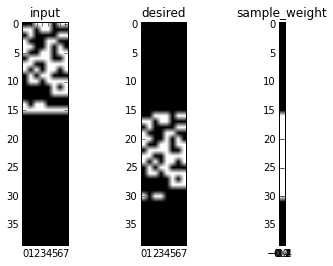

In [8]:
inp, out, sw = get_sample(1, 8, 20)

plt.subplot(131)
plt.title('input')
plt.imshow(inp[0], cmap='gray')
plt.subplot(132)
plt.title('desired')
plt.imshow(out[0], cmap='gray')
plt.subplot(133)
plt.title('sample_weight')
plt.imshow(sw[0], cmap='gray')

# sample_weight marks the points in time that will 
# be part of the cost function.

In [ ]:
# training uses sequences of length 1 to 20. Test uses series of length 100.
def test_model(model, file_name, min_size=100):
    I, V, sw = get_sample(batch_size=500, n_bits=input_dim, max_size=min_size+1, min_size=min_size)
    Y = np.asarray(model.predict(I, batch_size=100) > .5).astype('float64')
    acc = (V[:, -min_size:, :] == Y[:, -min_size:, :]).mean() * 100
    show_pattern(Y[0], V[0], sw[0], file_name)

    return acc

In [ ]:
trained = model

nb_epoch = 10000
progbar = generic_utils.Progbar(nb_epoch)
ACC = []
for e in range(nb_epoch):
    I, V, sw = get_sample(n_bits=input_dim, max_size=20, min_size=1, batch_size=100)
    
    # loss = trained.train_on_batch(I, V)[0]
    loss = trained.fit(I, V, sample_weight=sw, nb_epoch=1, batch_size=100, verbose=0).totals['loss']
    
    progbar.add(1, values=[("loss", loss)])
    
    if e % 500 == 0:
        print("")
        acc = test_model(trained, 'ntm_test.png')
        l = []
        for a in [acc,]:
            print("acc: {}".format(a))
            l.append(a)
        ACC.append(l)
        

    1/10000 [..............................] - ETA: 25029s - loss: 69.5857
acc: 49.97775
  501/10000 [>.............................] - ETA: 22062s - loss: 62.7876
acc: 50.2265
 1001/10000 [==>...........................] - ETA: 21897s - loss: 59.2485
acc: 50.2985
 1501/10000 [===>..........................] - ETA: 20979s - loss: 56.0201
acc: 50.25875
 2001/10000 [=====>........................] - ETA: 19904s - loss: 52.7980
acc: 51.8595
 2501/10000 [======>.......................] - ETA: 18734s - loss: 49.6904
acc: 52.5685
 3001/10000 [========>.....................] - ETA: 17361s - loss: 46.7947
acc: 52.70925
 3501/10000 [=========>....................] - ETA: 16173s - loss: 44.2186
acc: 52.83875
 4001/10000 [===========>..................] - ETA: 14779s - loss: 42.0098
acc: 53.06125
 4501/10000 [============>.................] - ETA: 12400s - loss: 40.0305
acc: 53.41525
 5001/10000 [==============>...............] - ETA: 10439s - loss: 38.2621
acc: 53.5355
 5501/10000 [=============

# Visualization

In [ ]:
X = model.get_input()
Y = ntm.get_full_output()[0:3] # (memory over time, read_vectors, write_vectors)
F = function([X], Y, allow_input_downcast=True)

In [21]:
inp, out, sw = get_sample(1, 8, 21, 20)

In [22]:
mem, read, write = F(inp.astype('float32'))
Y = model.predict(inp)

In [23]:
mem.shape

(1, 41, 121, 20)

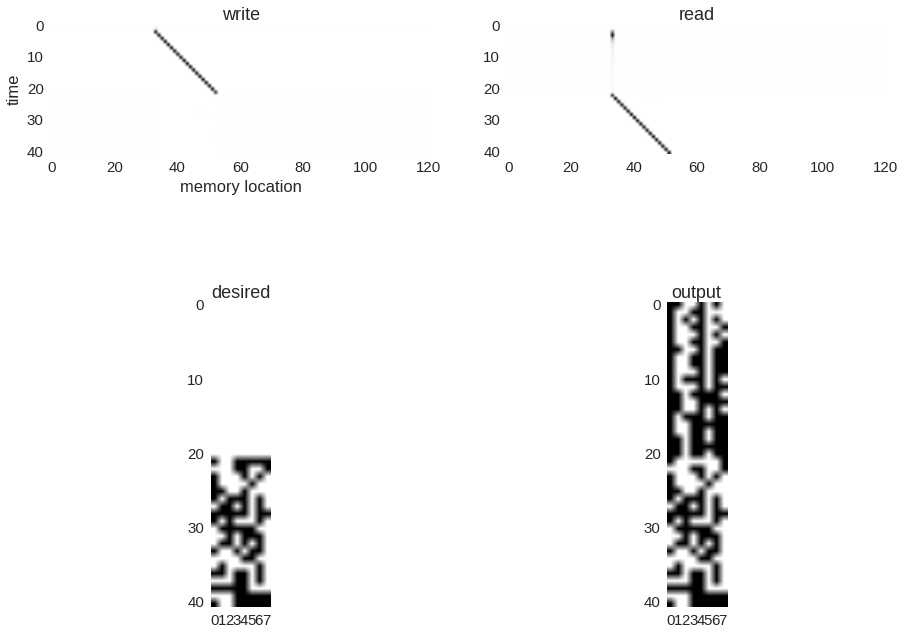

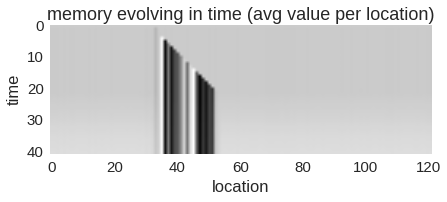

In [24]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.imshow(write[0])
plt.xlabel('memory location')
plt.ylabel('time')
plt.title('write')

plt.subplot(222)
plt.imshow(read[0])
plt.title('read')

plt.subplot(223)
plt.title('desired')
plt.imshow(out[0])

plt.subplot(224)
plt.imshow(Y[0]>.5)
plt.title('output')

plt.figure(figsize=(15, 10))
plt.subplot(325)
plt.ylabel('time')
plt.xlabel('location')
plt.title('memory evolving in time (avg value per location)')
plt.imshow(mem[0].mean(axis=-1))